## run this cell before starting spark cluster connection (corrects module error)

In [36]:
import os
print os.environ['PYSPARK_PYTHON']
os.environ['PYSPARK_PYTHON']=os.environ['LCG_VIEW'] + '/bin/python'
print os.environ['PYSPARK_PYTHON']

/cvmfs/sft.cern.ch/lcg/views/LCG_93/x86_64-slc6-gcc62-opt/bin/python
/cvmfs/sft.cern.ch/lcg/views/LCG_93/x86_64-slc6-gcc62-opt/bin/python


### Import necessary spark and python stuff

In [37]:
from pyspark.sql.functions import *
from pyspark.sql.types import *
from pyspark.sql.functions import from_json
from pyspark.ml.feature import VectorAssembler

In [38]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

pd.set_option('display.max_columns', 500)

### select the data

In [39]:
df = spark.read.json("/user/sprenner/training_official_april.json")

In [40]:
df.describe().toPandas()

summary  account           accountHash         clientState  \
0   count   777286                777286              777286   
1    mean     None   1.935684591732567E8                None   
2  stddev     None  1.1361317241087072E9                None   
3     min  aagaard           -2127257360  CannotAuthenticate   
4     max   zzheng            2143592175      SourceNotFound   

        clientStateHash                                            dataset  \
0                777286                                             777286   
1   -9.74016245191591E8                                               None   
2  2.6212986830087784E8                                               None   
3           -1922357674  data10_hi.00169927.physics_bulk.ROOT.NTUP_HI.r...   
4            1269532611  mc16_valid.423105.Pythia8EvtGen_A14NNPDF23LO_g...   

            datasetHash datasetScope      datasetScopeHash dataset_version  \
0                777286       777286                777286          777286   
1  1.4554549800768314E7         None  -7.552649492442358E8            None   
2  1.1941649925847795E9         None   8.314865501449603E8            None   
3           -2147401420    data10_hi           -2057006107     c1130_m1847   
4            2147445885   mc16_valid            2109319881      x557_m1947   

    dataset_versionHash datatype          datatypeHash eventType  \
0                777286   777286                777286    777286   
1   2.973310495739393E8     None   4.947060556405943E8      None   
2  1.2288188131163657E9     None  1.1700303292632797E9      None   
3           -2146716518      AOD           -2070622869  download   
4            2146405934      log            2124512252  download   

          eventTypeHash eventVersion      eventVersionHash  \
0                777286       777286                777286   
1            5.937808E7         None  -1.992468944589716E9   
2  6.539497870914422E-9         None  3.0732739647461045E8   
3              59378080       1.13.2           -2044360925   
4              59378080       1.15.5            1261702107   

                             filename          filenameHash  \
0                              777286                777286   
1                                None   -248557.46481861244   
2                                None  1.2402658149710777E9   
3    AOD.05371635._000001.pool.root.1           -2147478094   
4  log.13787275._000072.job.log.tgz.1            2147482617   

        filesize_double                hits                  hostname  \
0                777286              777286                    777286   
1    6.11402028756827E8  2.8777927300890536                      None   
2  1.2408771809945774E9  3.9916293684162345                      None   
3                 304.0                   1    ReCaS-ui-01.cs.infn.it   
4       1.1991446515E10                  48  xenia.nevis.columbia.edu   

            hostnameHash prod_step          prod_stepHash     project  \
0                 777286    777286                 777286      777286   
1  -1.1804844919942595E8      None  -3.3290311308177426E7        None   
2   1.2286452227051141E9      None    1.105007303744955E9        None   
3            -2133418459  PhysCont            -1329401808   data10_hi   
4             2129595856     simul             2037678380  mc16_valid   

            projectHash protocol          protocolHash             remoteSite  \
0                777286   777286                777286                 777286   
1  -7.551860864380562E8     None  3.5590511037907284E8                   None   
2   8.315047181989845E8     None  1.0536208601928809E9                   None   
3           -2057006107     davs           -1607963002        AGLT2_CALIBDISK   
4            2109319881      srm            2128034789  ZA-WITS-CORE_PRODDISK   

         remoteSiteHash          run_number       run_numberHash       scope  \
0                777286              777286               777286      777

### Separating the features from the target variable

In [41]:
assembler = VectorAssembler(
    inputCols=["traceTimeentryUnix", "transferStart", "accountHash","clientStateHash","datasetHash", "datasetScopeHash",
               "eventTypeHash", "eventVersionHash","filenameHash", "hostnameHash", "protocolHash", "remoteSiteHash", 
               "scopeHash", "traceIdHash", "traceIpHash", "uuidHash", "projectHash", "run_numberHash", "stream_nameHash",
               "prod_stepHash","datatypeHash","filesize_double"],
    outputCol="features")

#linearRegression will look for a column called features
output = assembler.transform(df)

In [42]:
#output = output.select("hits", "features")

### Split the data into train and test sets

In [43]:
train_data, test_data = output.randomSplit([.8,.2],seed=1234)

train_data.count()

621773

In [44]:
test_data.count()

155513

### perform linear regression

In [45]:
from pyspark.ml.regression import LinearRegression

#finetuning: https://spark.apache.org/docs/2.1.0/ml-tuning.html
# https://spark.apache.org/docs/2.1.0/api/python/pyspark.ml.html#pyspark.ml.regression.LinearRegression

lr = LinearRegression(labelCol="hits", maxIter=10, regParam=0.3, elasticNetParam=0.8)

In [46]:
linearModel = lr.fit(train_data)

In [47]:
linearModel.numFeatures

22

In [48]:
linearModel.summary.residuals

DataFrame[residuals: double]

In [49]:
linearModel.coefficients

DenseVector([0.0, 0.0, 0.0, -0.0, -0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])

In [50]:
linearModel.intercept

-100.57639062207826

In [51]:
linearModel.summary.rootMeanSquaredError

3.607314083259951

In [52]:
linearModel.summary.r2

0.17783743816347264

### Generate predictions

In [53]:
predicted = linearModel.transform(test_data)
predicted.limit(5).toPandas()

account  accountHash         clientState  clientStateHash  \
0   aagaard   1502895326                DONE       -878527175   
1   abuzatu    154527496                DONE       -878527175   
2   abuzatu    154527496                DONE       -878527175   
3  acanesse  -1913829851  ServiceUnavailable      -1394468120   
4  acukierm   1777994965                DONE       -878527175   

                                             dataset  datasetHash  \
0  mc15_13TeV.370179.MGPy8EG_A14N_GG_ttn1_2000_50...   1199729292   
1  mc16_13TeV.410501.PowhegPythia8EvtGen_A14_ttba...   -750525813   
2  mc16_13TeV.410501.PowhegPythia8EvtGen_A14_ttba...   -750525813   
3  mc16_13TeV.361106.PowhegPythia8EvtGen_AZNLOCTE...   1105772576   
4  mc15_13TeV.343981.PowhegPythia8EvtGen_NNLOPS_n...    746881300   

  datasetScope  datasetScopeHash                dataset_version  \
0   mc15_13TeV         337785635                    e4049_p3075   
1   mc16_13TeV       -1447489496  e5458_s3126_r9781_r9778_p3384   
2   mc16_13TeV       -1447489496  e5458_s3126_r9781_r9778_p3384   
3   mc16_13TeV       -1447489496       e3601_e5984_s3126_r10244   
4   mc15_13TeV         337785635                          e5607   

   dataset_versionHash     datatype  datatypeHash eventType  eventTypeHash  \
0            190291431  DAOD_TRUTH3     805082742  download       59378080   
1          -1787879578  NTUP_PILEUP    1967069222  download       59378080   
2          -1787879578  NTUP_PILEUP    1967069222  download       59378080   
3            157220216          RDO    -134998320  download       59378080   
4           2055325324          TXT    -339535536  download       59378080   

  eventVersion  eventVersionHash                                  filename  \
0      1.14.11       -2044360925  DAOD_TRUTH3.11034783._000001.pool.root.1   
1      1.14.11       -2044360925  NTUP_PILEUP.12628104._000051.pool.root.1   
2      1.14.11       -2044360925  NTUP_PILEUP.12628104._000055.pool.root.1   
3      1.14.11       -2044360925          RDO.13121605._000027.pool.root.1   
4      1.14.11       -2044360925             TXT.10248297._000076.tar.gz.1   

   filenameHash  filesize_double  hits           hostname  hostnameHash  \
0    1702353324     3.724975e+08     1  lxplus016.cern.ch     327922848   
1    1894289108     1.235700e+04     5     ipas06.cern.ch    -576117302   
2    1018072302     1.235700e+04     6     ipas06.cern.ch    -576117302   
3   -2035548476     3.109845e+09     3  lxplus068.cern.ch     162161216   
4     286278511     3.527239e+06     1  lxplus082.cern.ch    -964809119   

  prod_step  prod_stepHash     project  projectHash protocol  protocolHash  \
0     merge      874345773  mc15_13TeV    337785635      srm     863299160   
1     deriv    -1058503065  mc16_13TeV  -1447489496      srm     863299160   
2     deriv    -1058503065  mc16_13TeV  -1447489496   gsiftp    2128034789   
3     recon       92057515  mc16_13TeV  -1447489496     davs    1055219606   
4     evgen     2037678380  mc15_13TeV    337785635     root   -1364943180   

               remoteSite  remoteSiteHash run_number  run_numberHash  \
0  MWT2_UC_LOCALGROUPDISK      1050347905     370179      -238108560   
1        NDGF-T1_DATADISK      -873050461     410501     -2005429305   
2      CERN-PROD_DATADISK     -2057286004     410501     -2005429305   
3        NDGF-T1_DATADISK      -873050461     361106       -23332211   
4      CERN-PROD_DATADISK     -2057286004     343981      1938156175   

        scope   scopeHash                                        stream_name  \
0  mc15_13TeV   337785635                 MGPy8EG_A14N_GG_ttn1_2000_5000_200   
1  mc16_13TeV -1447489496  PowhegPythia8EvtGen_A14_ttbar_hdamp258p75_nona...   
2  mc16_13TeV -1447489496  PowhegPythia8EvtGen_A14_ttbar_hdamp258p75_nona...   
3  mc16_13TeV -1447489496               PowhegPythia8EvtGen_AZNLOCTEQ6L1_Zee   
4  mc15_13TeV   337785635   PowhegPythia8EvtGen_NNLOPS_nnlo_30_ggH125_gamgam   

   stream_nameHash     

In [54]:
# https://stackoverflow.com/questions/35882446/spark-convert-data-frame-column-to-vectors-dense
df_pd = predicted.toPandas()

In [55]:
df_pd = df_pd.sort_values('prediction')
df_pd = df_pd.reset_index(drop=True)
df_pd

account  accountHash         clientState  clientStateHash  \
0       rdinardo   -268115595     RSEAccessDenied       1269532611   
1        mpettee   -826835163           Exception        634051254   
2        mpettee   -826835163           Exception        634051254   
3        mpettee   -826835163           Exception        634051254   
4        mpettee   -826835163           Exception        634051254   
5        mpettee   -826835163           Exception        634051254   
6        mpettee   -826835163           Exception        634051254   
7        mpettee   -826835163           Exception        634051254   
8        mpettee   -826835163           Exception        634051254   
9        mpettee   -826835163           Exception        634051254   
10       mpettee   -826835163           Exception        634051254   
11       mpettee   -826835163           Exception        634051254   
12      ellingha   -171710354           Exception        634051254   
13      ellingha   -171710354           Exception        634051254   
14       mpettee   -826835163           Exception        634051254   
15       mpettee   -826835163           Exception        634051254   
16       mpettee   -826835163           Exception        634051254   
17       mpettee   -826835163           Exception        634051254   
18      toyamaza    368790896           Exception        634051254   
19      toyamaza    368790896           Exception        634051254   
20      toyamaza    368790896           Exception        634051254   
21      toyamaza    368790896           Exception        634051254   
22      fspeiser   1054367559       FAIL_VALIDATE        327185723   
23      fspeiser   1054367559       FAIL_VALIDATE        327185723   
24      fspeiser   1054367559       FAIL_VALIDATE        327185723   
25      fspeiser   1054367559       FAIL_VALIDATE        327185723   
26       mazhang    333128004       FAIL_VALIDATE        327185723   
27         kchoi   -615560788       FAIL_VALIDATE        327185723   
28      salvucci  -1443025687       FAIL_VALIDATE        327185723   
29        isiral  -1891614446       FAIL_VALIDATE        327185723   
...          ...          ...                 ...              ...   
155483   hatmani  -1973289280  ServiceUnavailable      -1394468120   
155484   hatmani  -1973289280  ServiceUnavailable      -1394468120   
155485   hatmani  -1973289280  ServiceUnavailable      -1394468120   
155486   hatmani  -1973289280  ServiceUnavailable      -1394468120   
155487   hatmani  -1973289280  ServiceUnavailable      -1394468120   
155488   hatmani  -1973289280  ServiceUnavailable      -1394468120   
155489   hatmani  -1973289280  ServiceUnavailable      -1394468120   
155490   hatmani  -1973289280  ServiceUnavailable      -1394468120   
155491   hatmani  -1973289280  ServiceUnavailable      -1394468120   
155492   hatmani  -1973289280  ServiceUnavailable      -1394468120   
155493   hatmani  -1973289280  ServiceUnavailable      -1394468120   
155494   hatmani  -1973289280  ServiceUnavailable      -1394468120   
155495   hatmani  -1973289280  ServiceUnavailable      -1394468120   
155496   hatmani  -1973289280  ServiceUnavailable      -1394468120   
155497   hatmani  -1973289280  ServiceUnavailable      -1394468120   
155498   hatmani  -1973289280  ServiceUnavailable      -1394468120   
155499   hatmani  -1973289280  ServiceUnavailable      -1394468120   
155500   hatmani  -1973289280  ServiceUnavailable      -1394468120   
155501   hatmani  -1973289280  ServiceUnavailable      -1394468120   
155502   hatmani  -1973289280  ServiceUnavailable      -1394468120   
155503   hatmani  -1973289280  ServiceUnavailable      -1394468120   
155504   hatmani  -1973289280  ServiceUnavailable      -1394468120   
155505   hatmani  -1973289280  ServiceUnavailable      -1394468120   
155506   hatmani  -1973289280  ServiceUnavailable      -1394468120   
155507   hatmani  -1973289280  ServiceUnavailable      -1394468120   
155508   hatmani  -

In [56]:
plt.rcParams['agg.path.chunksize'] = 10000

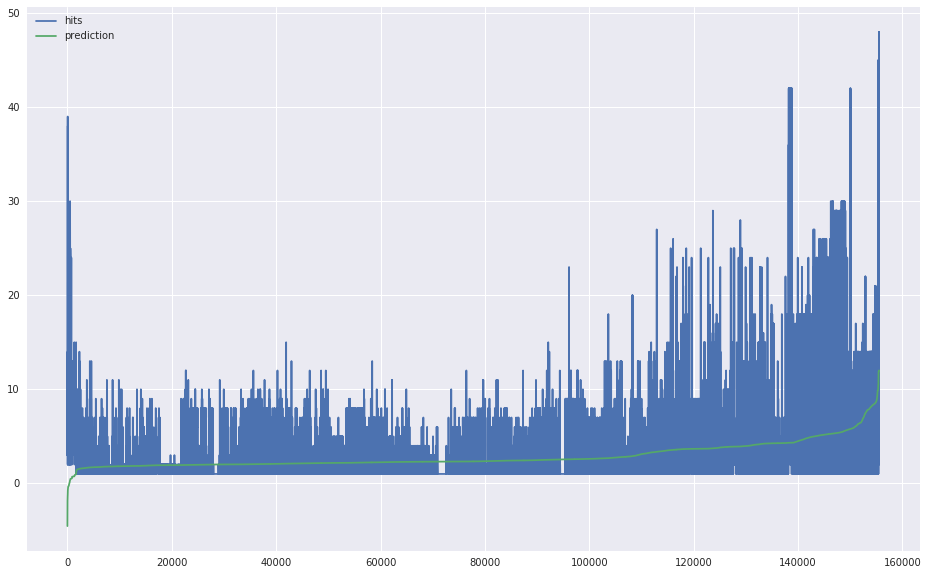

In [57]:
df_pd[['hits','prediction']].plot(figsize=(16,10))

In [58]:
df_mai = spark.read.json("/user/sprenner/training_official_mai.json")

In [59]:
df_mai.describe().toPandas()

summary   account           accountHash         clientState  \
0   count    589283                589283              589283   
1    mean      None  -7.873822054121874E7                None   
2  stddev      None  1.1303640225554879E9                None   
3     min     abell           -2123889579  CannotAuthenticate   
4     max  zmarshal            2140382084      SourceNotFound   

         clientStateHash                                            dataset  \
0                 589283                                             589283   
1  -1.0635692705599144E9                                               None   
2   2.7545692038495237E8                                               None   
3            -1913538301  data12_8TeV.00200805.physics_MinBias.recon.NTU...   
4              634051254  mc16_valid.361034.Pythia8EvtGen_A2MSTW2008LO_m...   

             datasetHash datasetScope      datasetScopeHash dataset_version  \
0                 589283       589283                589283          589283   
1  -1.4774623149099838E7         None  -9.356107326362851E8            None   
2   1.2687544178588226E9         None   6.784957656574688E8            None   
3            -2147401420  data12_8TeV           -2057006107     c1128_m1842   
4             2147445885   mc16_valid            2109319881      x563_m1972   

    dataset_versionHash datatype          datatypeHash eventType  \
0                589283   589283                589283    589283   
1  -3.730470822323909E7     None  2.1895068833955333E8      None   
2  1.1014652354502916E9     None  1.0743326832603397E9      None   
3           -2144917680      AOD           -2070622869  download   
4            2146973161      log            2124512252  download   

  eventTypeHash eventVersion       eventVersionHash  \
0        589283       589283                 589283   
1    5.937808E7         None  -2.0115120046498694E9   
2           0.0         None   3.1656468733263844E8   
3      59378080      1.14.10            -2044360925   
4      59378080       1.16.1             1261702107   

                             filename         filenameHash  \
0                              589283               589283   
1                                None    684033.7623824207   
2                                None  1.239027645346361E9   
3    AOD.05341490._000446.pool.root.1          -2147471303   
4  log.14217468._003414.job.log.tgz.1           2147478625   

        filesize_double               hits                  hostname  \
0                589283             589283                    589283   
1  1.4339739956710258E9  4.395322790577702                      None   
2     2.1931399445812E9  6.041694435706456                      None   
3                9576.0                  1    ReCaS-ui-01.cs.infn.it   
4       1.1976018886E10                 85  xenia.nevis.columbia.edu   

           hostnameHash prod_step          prod_stepHash      project  \
0                589283    589283                 589283       589283   
1  -4.071422388835245E7      None  -2.5500199104117885E8         None   
2     9.7563849011858E8      None    9.244506692727857E8         None   
3           -2138306752  PhysCont            -1058503065  data12_8TeV   
4            2129595856     simul             2037678380   mc16_valid   

            projectHash protocol          protocolHash  \
0                589283   589283                589283   
1  -9.356107326362851E8     None  4.4731323734995073E8   
2   6.784957656574688E8     None   1.103659075718831E9   
3           -2057006107     davs           -1607963002   
4            2109319881      srm            2128034789   

                  remoteSite         remoteSiteHash         run_number  \
0                     589283                 589283             589283   
1                       None  -4.1575698659324807E8  350085.3422377267   
2                       None   1.1945524910628088E9  47777.01099327565   
3            AGLT2_CALIBDISK   

In [60]:
assembler_mai = VectorAssembler(
    inputCols=["traceTimeentryUnix", "transferStart", "accountHash","clientStateHash","datasetHash", "datasetScopeHash",
               "eventTypeHash", "eventVersionHash","filenameHash", "hostnameHash", "protocolHash", "remoteSiteHash", 
               "scopeHash", "traceIdHash", "traceIpHash", "uuidHash", "projectHash", "run_numberHash", "stream_nameHash",
               "prod_stepHash","datatypeHash","filesize_double"],
    outputCol="features")

#linearRegression will look for a column called features
output_mai = assembler_mai.transform(df_mai)

In [61]:
predicted_mai = linearModel.transform(output_mai)

In [62]:
predicted_mai.describe().toPandas()

summary   account           accountHash         clientState  \
0   count    589283                589283              589283   
1    mean      None  -7.873822054121874E7                None   
2  stddev      None  1.1303640225554879E9                None   
3     min     abell           -2123889579  CannotAuthenticate   
4     max  zmarshal            2140382084      SourceNotFound   

         clientStateHash                                            dataset  \
0                 589283                                             589283   
1  -1.0635692705599144E9                                               None   
2    2.754569203849524E8                                               None   
3            -1913538301  data12_8TeV.00200805.physics_MinBias.recon.NTU...   
4              634051254  mc16_valid.361034.Pythia8EvtGen_A2MSTW2008LO_m...   

             datasetHash datasetScope      datasetScopeHash dataset_version  \
0                 589283       589283                589283          589283   
1  -1.4774623149099838E7         None  -9.356107326362851E8            None   
2   1.2687544178588228E9         None   6.784957656574687E8            None   
3            -2147401420  data12_8TeV           -2057006107     c1128_m1842   
4             2147445885   mc16_valid            2109319881      x563_m1972   

    dataset_versionHash datatype          datatypeHash eventType  \
0                589283   589283                589283    589283   
1  -3.730470822323909E7     None  2.1895068833955333E8      None   
2  1.1014652354502916E9     None  1.0743326832603395E9      None   
3           -2144917680      AOD           -2070622869  download   
4            2146973161      log            2124512252  download   

  eventTypeHash eventVersion       eventVersionHash  \
0        589283       589283                 589283   
1    5.937808E7         None  -2.0115120046498694E9   
2           0.0         None   3.1656468733263844E8   
3      59378080      1.14.10            -2044360925   
4      59378080       1.16.1             1261702107   

                             filename          filenameHash  \
0                              589283                589283   
1                                None     684033.7623824207   
2                                None  1.2390276453463612E9   
3    AOD.05341490._000446.pool.root.1           -2147471303   
4  log.14217468._003414.job.log.tgz.1            2147478625   

        filesize_double               hits                  hostname  \
0                589283             589283                    589283   
1  1.4339739956710258E9  4.395322790577702                      None   
2  2.1931399445812006E9  6.041694435706456                      None   
3                9576.0                  1    ReCaS-ui-01.cs.infn.it   
4       1.1976018886E10                 85  xenia.nevis.columbia.edu   

           hostnameHash prod_step          prod_stepHash      project  \
0                589283    589283                 589283       589283   
1  -4.071422388835245E7      None  -2.5500199104117885E8         None   
2   9.756384901185799E8      None    9.244506692727857E8         None   
3           -2138306752  PhysCont            -1058503065  data12_8TeV   
4            2129595856     simul             2037678380   mc16_valid   

            projectHash protocol          protocolHash  \
0                589283   589283                589283   
1  -9.356107326362851E8     None  4.4731323734995073E8   
2   6.784957656574687E8     None   1.103659075718831E9   
3           -2057006107     davs           -1607963002   
4            2109319881      srm            2128034789   

                  remoteSite         remoteSiteHash         run_number  \
0                     589283                 589283             589283   
1                       None  -4.1575698659324807E8  350085.3422377267   
2                       None    1.194552491062809E9  47777.01099327565   
3            AGLT2_CALIBD

In [63]:
df_pd_mai = predicted_mai[['hits','prediction']].toPandas()

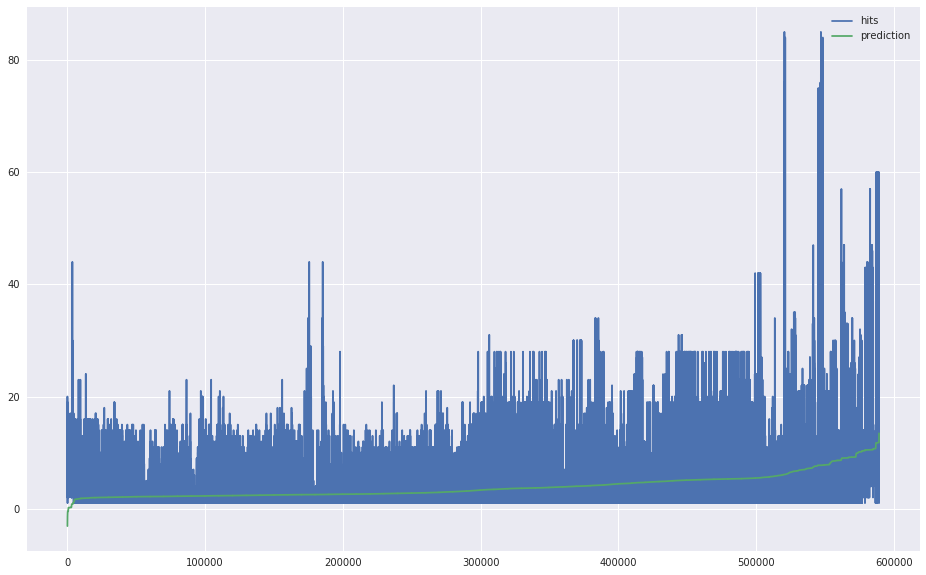

In [64]:
df_pd_mai = df_pd_mai.sort_values('prediction')
df_pd_mai = df_pd_mai.reset_index(drop=True)
df_pd_mai.plot(figsize=(16,10))

In [65]:
predicted_mai=predicted_mai.withColumn("filesize", predicted_mai["filesize_double"].cast(IntegerType()))

In [66]:
predicted_mai = predicted_mai.drop('filesize_double')

In [67]:
df_mai_sim = predicted_mai.select('uuid', 'account', 'dataset', 'filename', 'eventType', 'clientState', 
                                  from_unixtime(predicted_mai.traceTimeentryUnix, format='yyyy-MM-dd').alias('day'), 'traceTimeentryUnix', 
                                  'filesize', 'prediction').sort(col("day").asc())

In [68]:
df_mai_sim.limit(5).toPandas()

uuid account  \
0  3381eae153f34a9aa0b33e1039de9b9a   cylin   
1  d2169772ab5f49b7b33de1a14902f175   cylin   
2  3381eae153f34a9aa0b33e1039de9b9a   cylin   
3  d2169772ab5f49b7b33de1a14902f175   cylin   
4  d2169772ab5f49b7b33de1a14902f175   cylin   

                                             dataset  \
0  mc16_13TeV.361021.Pythia8EvtGen_A14NNPDF23LO_j...   
1  mc16_13TeV.361021.Pythia8EvtGen_A14NNPDF23LO_j...   
2  mc16_13TeV.361021.Pythia8EvtGen_A14NNPDF23LO_j...   
3  mc16_13TeV.361021.Pythia8EvtGen_A14NNPDF23LO_j...   
4  mc16_13TeV.361021.Pythia8EvtGen_A14NNPDF23LO_j...   

                           filename eventType         clientState         day  \
0  AOD.12911492._000019.pool.root.1  download  ServiceUnavailable  2018-05-01   
1  AOD.12911492._000019.pool.root.1  download  ServiceUnavailable  2018-05-01   
2  AOD.12911492._000019.pool.root.1  download  ServiceUnavailable  2018-05-01   
3  AOD.12911492._000019.pool.root.1  download  ServiceUnavailable  2018-05-01   
4  AOD.12911492._000019.pool.root.1  download  ServiceUnavailable  2018-05-01   

   traceTimeentryUnix    filesize  prediction  
0        1.525178e+09  2147483647    7.751070  
1        1.525169e+09  2147483647    7.750482  
2        1.525178e+09  2147483647    7.751091  
3        1.525169e+09  2147483647    7.750476  
4        1.525169e+09  2147483647    7.750476

In [ ]:
#df_mai_sim.write.csv('/user/sprenner/linear_regression_mai_official_predictions_maxIter10_regParam03_elasticNetParam08.csv', sep='\t')